In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

# CEO-REQUEST CHALLENGE

## Problem statement

We would like to analyse the impact of removing the most-underperforming sellers from Olist marketplace.

For that:

1) You may want to compute, for each `seller_id`, and cumulated over the course of the past 16 months of data we have:
- The revenues it brings (10% of each sales + 80 BRL per month)
- The costs associated with all its bad reviews (1-star = 100 BRL, 2-star = 50, 3-star=40)
- The resulting profits (revenues - costs)
- You also want to keep track of the number of orders that this seller has been responsible for (it will impact overall IT costs) ultimately


2) Then, we may want to sort sellers by increasing profit for Olist, and compute the financial impact it would have made if we had removed some sellers from the platform. We may find an optimal number of seller to remove that maximizes total_profits or margins

---
❓ Second, take time to 

**Write down the DataFrame you would need to build to answer the question?**
write down in plain english a step-by-step approach** to your goal. 

Try not to start from scratch, but think instead about what logic you have already coded in your `olist` package, and how can they be used **or modified** to give you the desired outcome. Your codebase is not set in stone - feel free to add new methods as needed!

<details>
    <summary>Hints</summary>


Starting from your current `seller().get_training_data()` DataFrame:
- Can you easily transform it to compute Olist's positive `revenue_per_seller`? 
- Can you easily transform it to compute Olist's `cost_of_bad_reviews`?

❓Instead of starting again from scratch, investigate in your source code in `seller.py` how was computed the mean `review_score` per seller. Can you imagine a way to ammend your code so as to compute `cost_of_reviews` in the same process ? 
</details>


In [2]:
# Write down a detailed strategy (steps by step) to get to this final DataFrame

- Update `seller.py` to compute a missing `cost_of_reviews` column
- Compute `months_on_olist` and `revenues` using existing seller_training_data columns
- Compute `profits` per seller
- Sort DataFrame per `profits`
- Remove worse performing seller one by one, and for each scenario:
    - compute `n_orders` and therefore `olist_it_costs` (prop to square root of n_orders)
    - compute Olist's total `net_profits` and `margin`
- Find the optimal number of seller to remove from platform so as to maximize `profit` or `margin`

## Update `seller.py`

In [1]:
from olist.seller_updated import Seller
seller = Seller()

## Economic analysis

In [2]:
olist_it_costs_all_orders = 500000

In [3]:
sellers = seller.get_training_data()

In [4]:
olist_revenues = sellers.revenues.sum()
olist_gross_profits = sellers.profits.sum()
olist_gross_profits

1116965.223999999

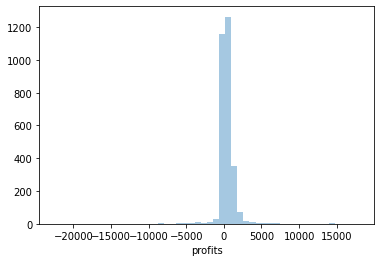

In [7]:
sns.distplot(sellers.profits, kde=False)

In [8]:
sorted_sellers = sellers.sort_values(by='profits')[['profits', 'n_orders', 'revenues']].reset_index()
sorted_sellers.head()

,index,profits,n_orders,revenues
0,769,-22499.517,1854,13770.483
1,2360,-19242.708,1806,21647.292
2,1358,-18051.158,1706,11948.842
3,946,-16032.248,1146,4677.752
4,315,-13066.431,943,2553.569


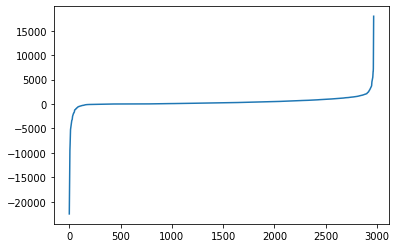

In [9]:
sorted_sellers.profits.plot()

### Compute Olist's net_profits for various seller cut-offs

In [10]:
# Let's create arrays "xxx_per_seller_removed" which list,
# for each number of seller removed (from 1 to len(seller)), 
# the value xxx computed in this hypothetic scenario

In [11]:
sorted_sellers.profits

0      -22499.517
1      -19242.708
2      -18051.158
3      -16032.248
4      -13066.431
          ...    
2965     6700.462
2966     7288.455
2967    14254.203
2968    14523.187
2969    17967.605
Name: profits, Length: 2970, dtype: float64

Text(0.5, 0, 'number of seller to remove')

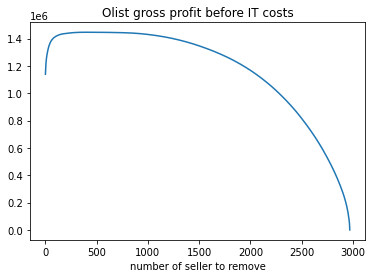

In [12]:
# Analysis before IT costs
revenues_per_seller_removed = olist_revenues - np.cumsum(sorted_sellers.revenues)
gross_profits_per_seller_removed = olist_gross_profits - np.cumsum(sorted_sellers.profits)

gross_profits_per_seller_removed.plot()
plt.title('Olist gross profit before IT costs')
plt.xlabel('number of seller to remove')

In [10]:
# Add the IT costs of Olist's platform, which scales as A * (n_orders)**0.5
# First, compute A
A = olist_it_costs_all_orders / (sellers['n_orders'].sum()**0.5)
A

1582.3735631973473

Text(0.5, 0, 'number of seller to remove')

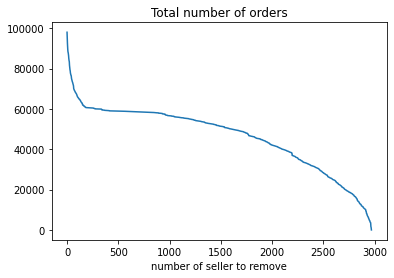

In [22]:
# Then, compute n_order per scenario
n_orders_per_seller_removed = sorted_sellers.n_orders.sum() - np.cumsum(sorted_sellers.n_orders)
plt.plot(n_orders_per_seller_removed)
plt.title('Total number of orders')
plt.xlabel('number of seller to remove')

Text(0.5, 0, 'number of seller to remove')

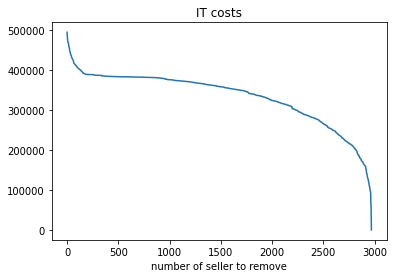

In [23]:
# Create array of it_costs per scenario
it_costs_per_seller_removed = A * n_orders_per_seller_removed**0.5
plt.plot(it_costs_per_seller_removed)
plt.title('IT costs')
plt.xlabel('number of seller to remove')

In [24]:
# Compute final metrics (profits and margin, for each 2970 scenarios!)
profits_per_seller_removed = gross_profits_per_seller_removed - it_costs_per_seller_removed
margin_per_seller_removed = profits_per_seller_removed / revenues_per_seller_removed

array([   0,    1,    2, ..., 2966, 2967, 2968])

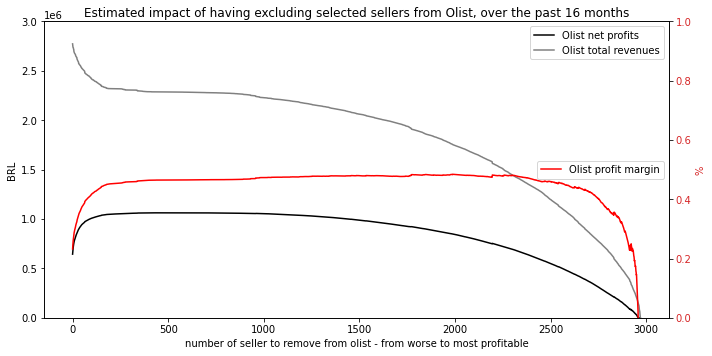

In [37]:
fig, ax1 = plt.subplots(figsize=(10,5))
x = np.arange(0, len(sellers), 1)

plt.suptitle("Estimated impact of having excluding selected sellers from Olist, over the past 16 months")

ax1.set_xlabel('number of seller to remove from olist - from worse to most profitable')
ax1.set_ylabel('BRL')
ax1.plot(x, profits_per_seller_removed, color='black', label='Olist net profits')
ax1.plot(x, revenues_per_seller_removed, color='grey', label='Olist total revenues')
ax1.legend()
ax1.tick_params(axis='y')
ax1.legend()
ax1.set(ylim=[0,3000000])


ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax3.set_ylabel('%', color=color)  # we already handled the x-label with ax1
ax3.plot(x, margin_per_seller_removed, color='red', label='Olist profit margin')
ax3.tick_params(axis='y', labelcolor=color)
ax3.legend(loc='right')
ax3.set(ylim=[0,1])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

☝️We can clearly see a trade-off with a maximim net_profit, at around 500 sellers to remove, and a maximum margin at about 2000 sellers removed. Beyond, margin collapses due to IT costs.

# CEO-REQUEST CHALLENGE

## Problem statement

We would like to analyse the impact of removing the most-underperforming sellers from Olist marketplace.

❓ **Formulate the problem mathematically**

<details>
    <summary>Hints</summary>

1) You may want to compute, for each `seller_id`:
- The revenue it brings (10% of each sales + 80 BRL per month)
- The cost associated with all its bad reviews (1-star = 100 BRL, 2-star = 50, 3-star=40)
- and the resulting profit per seller
- cumulated over the course of the past 16 months of data we have
    
2) We may then sort sellers by increasing profit for Olist and compute, the financial impact it would have made if we had removed some sellers from the platform.

</details>

In [1]:
# What is the final DataFrame you need to build to answer the question?

# [seller_id, months_on_olist, sales, cost_of_reviews]

---
❓ Second, take time to **write down in plain english a step-by-step approach** to your goal. 

Try not to start from scratch, but think instead about what logic you have already coded in your `olist` package, and how can they be used **or modified** to give you the desired outcome. Your codebase is not set in stone - feel free to add new methods as needed!

<details>
    <summary>Hints for seller-removal analysis</summary>


Starting from your current `seller().get_training_data()` DataFrame:
- Can you easily transform it to compute Olist's positive `revenue_per_seller`? 
- Can you easily transform it to compute Olist's `cost_of_bad_reviews`? Not directly from the mean `review_score`

❓Instead of starting again from scratch, investigate in your source code in `seller.py` how was computed the mean `review_score` per seller. Can you imagine a way to ammend your code so as to compute `cost_of_reviews` in the same process ? 
</details>


In [2]:
# Write down a detailed strategy (steps by step) to get to this final DataFrame

- Update `seller.py` to compute a missing `cost_of_reviews` column
- Compute `months_on_olist` and `revenues` using existing seller_training_data columns
- Compute `profits` per seller
- Sort DataFrame per `profits`
- Remove worse performing seller one by one, and for each scenario:
    - compute `n_orders` and therefore `olist_it_costs` (prop to square root of n_orders)
    - compute Olist's total `net_profits` and `margin`
- Find the optimal number of seller to remove from platform so as to maximize `profit` or `margin`

## Update `seller.py`

In [1]:
from olist.seller_updated import Seller
seller = Seller()

## Economic analysis

In [2]:
olist_it_costs_all_orders = 500000

In [3]:
sellers = seller.get_training_data()

In [4]:
olist_revenues = sellers.revenues.sum()
olist_gross_profits = sellers.profits.sum()
olist_gross_profits

1116965.223999999

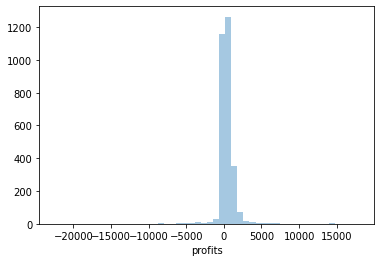

In [7]:
sns.distplot(sellers.profits, kde=False)

In [8]:
sorted_sellers = sellers.sort_values(by='profits')[['profits', 'n_orders', 'revenues']].reset_index()
sorted_sellers.head()

,index,profits,n_orders,revenues
0,769,-22499.517,1854,13770.483
1,2360,-19242.708,1806,21647.292
2,1358,-18051.158,1706,11948.842
3,946,-16032.248,1146,4677.752
4,315,-13066.431,943,2553.569


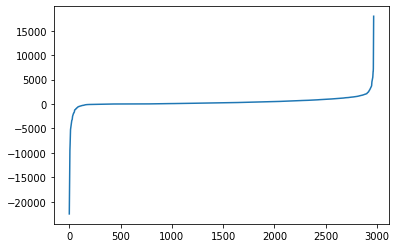

In [9]:
sorted_sellers.profits.plot()

### Compute Olist's net_profits for various seller cut-offs

In [10]:
# Let's create arrays "xxx_per_seller_removed" which list,
# for each number of seller removed (from 1 to len(seller)), 
# the value xxx computed in this hypothetic scenario

In [11]:
sorted_sellers.profits

0      -22499.517
1      -19242.708
2      -18051.158
3      -16032.248
4      -13066.431
          ...    
2965     6700.462
2966     7288.455
2967    14254.203
2968    14523.187
2969    17967.605
Name: profits, Length: 2970, dtype: float64

Text(0.5, 0, 'number of seller to remove')

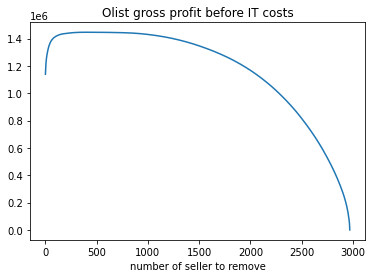

In [12]:
# Analysis before IT costs
revenues_per_seller_removed = olist_revenues - np.cumsum(sorted_sellers.revenues)
gross_profits_per_seller_removed = olist_gross_profits - np.cumsum(sorted_sellers.profits)

gross_profits_per_seller_removed.plot()
plt.title('Olist gross profit before IT costs')
plt.xlabel('number of seller to remove')

In [10]:
# Add the IT costs of Olist's platform, which scales as A * (n_orders)**0.5
# First, compute A
A = olist_it_costs_all_orders / (sellers['n_orders'].sum()**0.5)
A

1582.3735631973473

Text(0.5, 0, 'number of seller to remove')

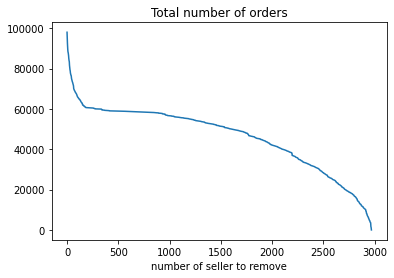

In [22]:
# Then, compute n_order per scenario
n_orders_per_seller_removed = sorted_sellers.n_orders.sum() - np.cumsum(sorted_sellers.n_orders)
plt.plot(n_orders_per_seller_removed)
plt.title('Total number of orders')
plt.xlabel('number of seller to remove')

Text(0.5, 0, 'number of seller to remove')

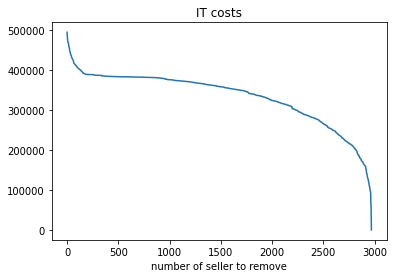

In [23]:
# Create array of it_costs per scenario
it_costs_per_seller_removed = A * n_orders_per_seller_removed**0.5
plt.plot(it_costs_per_seller_removed)
plt.title('IT costs')
plt.xlabel('number of seller to remove')

In [24]:
# Compute final metrics (profits and margin, for each 2970 scenarios!)
profits_per_seller_removed = gross_profits_per_seller_removed - it_costs_per_seller_removed
margin_per_seller_removed = profits_per_seller_removed / revenues_per_seller_removed

array([   0,    1,    2, ..., 2966, 2967, 2968])

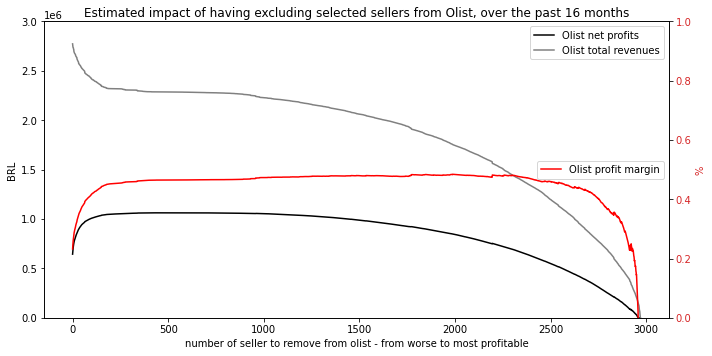

In [37]:
fig, ax1 = plt.subplots(figsize=(10,5))
x = np.arange(0, len(sellers), 1)

plt.suptitle("Estimated impact of having excluding selected sellers from Olist, over the past 16 months")

ax1.set_xlabel('number of seller to remove from olist - from worse to most profitable')
ax1.set_ylabel('BRL')
ax1.plot(x, profits_per_seller_removed, color='black', label='Olist net profits')
ax1.plot(x, revenues_per_seller_removed, color='grey', label='Olist total revenues')
ax1.legend()
ax1.tick_params(axis='y')
ax1.legend()
ax1.set(ylim=[0,3000000])


ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax3.set_ylabel('%', color=color)  # we already handled the x-label with ax1
ax3.plot(x, margin_per_seller_removed, color='red', label='Olist profit margin')
ax3.tick_params(axis='y', labelcolor=color)
ax3.legend(loc='right')
ax3.set(ylim=[0,1])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

☝️We can clearly see a trade-off with a maximim net_profit, at around 500 sellers to remove, and a maximum margin at about 2000 sellers removed. Beyond, margin collapses due to IT costs.

# CEO-REQUEST CHALLENGE

## Problem statement

We would like to analyse the impact of removing the most-underperforming sellers from Olist marketplace.

❓ **Formulate the problem mathematically**

<details>
    <summary>Hints</summary>

1) You may want to compute, for each `seller_id`:
- The revenue it brings (10% of each sales + 80 BRL per month)
- The cost associated with all its bad reviews (1-star = 100 BRL, 2-star = 50, 3-star=40)
- and the resulting profit per seller
- cumulated over the course of the past 16 months of data we have
    
2) We may then sort sellers by increasing profit for Olist and compute, the financial impact it would have made if we had removed some sellers from the platform.

</details>

In [1]:
# What is the final DataFrame you need to build to answer the question?

# [seller_id, months_on_olist, sales, cost_of_reviews]

---
❓ Second, take time to **write down in plain english a step-by-step approach** to your goal. 

Try not to start from scratch, but think instead about what logic you have already coded in your `olist` package, and how can they be used **or modified** to give you the desired outcome. Your codebase is not set in stone - feel free to add new methods as needed!

<details>
    <summary>Hints for seller-removal analysis</summary>


Starting from your current `seller().get_training_data()` DataFrame:
- Can you easily transform it to compute Olist's positive `revenue_per_seller`? 
- Can you easily transform it to compute Olist's `cost_of_bad_reviews`? Not directly from the mean `review_score`

❓Instead of starting again from scratch, investigate in your source code in `seller.py` how was computed the mean `review_score` per seller. Can you imagine a way to ammend your code so as to compute `cost_of_reviews` in the same process ? 
</details>


In [2]:
# Write down a detailed strategy (steps by step) to get to this final DataFrame

- Update `seller.py` to compute a missing `cost_of_reviews` column
- Compute `months_on_olist` and `revenues` using existing seller_training_data columns
- Compute `profits` per seller
- Sort DataFrame per `profits`
- Remove worse performing seller one by one, and for each scenario:
    - compute `n_orders` and therefore `olist_it_costs` (prop to square root of n_orders)
    - compute Olist's total `net_profits` and `margin`
- Find the optimal number of seller to remove from platform so as to maximize `profit` or `margin`

## Update `seller.py`

In [1]:
from olist.seller_updated import Seller
seller = Seller()

## Economic analysis

In [2]:
olist_it_costs_all_orders = 500000

In [3]:
sellers = seller.get_training_data()

In [4]:
olist_revenues = sellers.revenues.sum()
olist_gross_profits = sellers.profits.sum()
olist_gross_profits

1116965.223999999

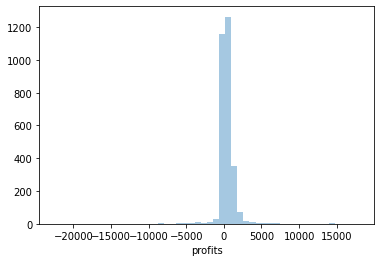

In [7]:
sns.distplot(sellers.profits, kde=False)

In [8]:
sorted_sellers = sellers.sort_values(by='profits')[['profits', 'n_orders', 'revenues']].reset_index()
sorted_sellers.head()

,index,profits,n_orders,revenues
0,769,-22499.517,1854,13770.483
1,2360,-19242.708,1806,21647.292
2,1358,-18051.158,1706,11948.842
3,946,-16032.248,1146,4677.752
4,315,-13066.431,943,2553.569


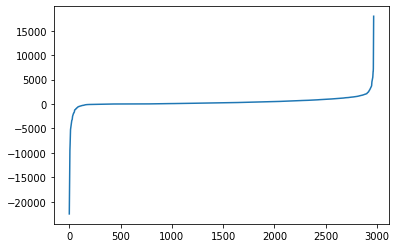

In [9]:
sorted_sellers.profits.plot()

### Compute Olist's net_profits for various seller cut-offs

In [10]:
# Let's create arrays "xxx_per_seller_removed" which list,
# for each number of seller removed (from 1 to len(seller)), 
# the value xxx computed in this hypothetic scenario

In [11]:
sorted_sellers.profits

0      -22499.517
1      -19242.708
2      -18051.158
3      -16032.248
4      -13066.431
          ...    
2965     6700.462
2966     7288.455
2967    14254.203
2968    14523.187
2969    17967.605
Name: profits, Length: 2970, dtype: float64

Text(0.5, 0, 'number of seller to remove')

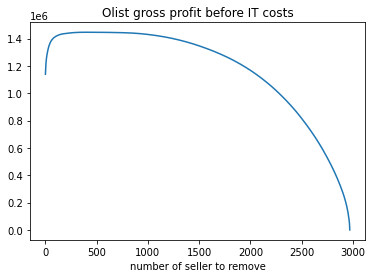

In [12]:
# Analysis before IT costs
revenues_per_seller_removed = olist_revenues - np.cumsum(sorted_sellers.revenues)
gross_profits_per_seller_removed = olist_gross_profits - np.cumsum(sorted_sellers.profits)

gross_profits_per_seller_removed.plot()
plt.title('Olist gross profit before IT costs')
plt.xlabel('number of seller to remove')

In [10]:
# Add the IT costs of Olist's platform, which scales as A * (n_orders)**0.5
# First, compute A
A = olist_it_costs_all_orders / (sellers['n_orders'].sum()**0.5)
A

1582.3735631973473

Text(0.5, 0, 'number of seller to remove')

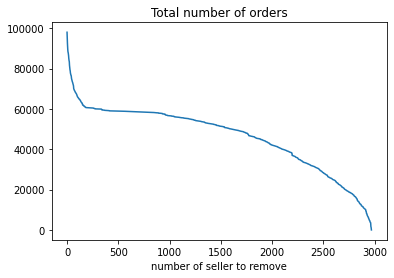

In [22]:
# Then, compute n_order per scenario
n_orders_per_seller_removed = sorted_sellers.n_orders.sum() - np.cumsum(sorted_sellers.n_orders)
plt.plot(n_orders_per_seller_removed)
plt.title('Total number of orders')
plt.xlabel('number of seller to remove')

Text(0.5, 0, 'number of seller to remove')

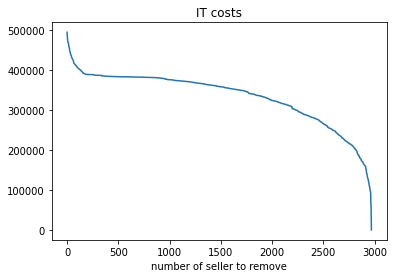

In [23]:
# Create array of it_costs per scenario
it_costs_per_seller_removed = A * n_orders_per_seller_removed**0.5
plt.plot(it_costs_per_seller_removed)
plt.title('IT costs')
plt.xlabel('number of seller to remove')

In [24]:
# Compute final metrics (profits and margin, for each 2970 scenarios!)
profits_per_seller_removed = gross_profits_per_seller_removed - it_costs_per_seller_removed
margin_per_seller_removed = profits_per_seller_removed / revenues_per_seller_removed

array([   0,    1,    2, ..., 2966, 2967, 2968])

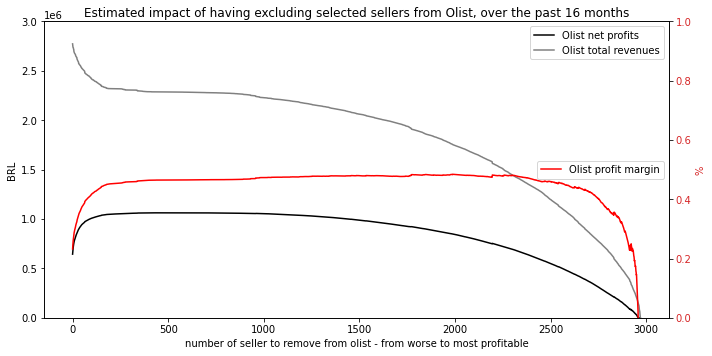

In [37]:
fig, ax1 = plt.subplots(figsize=(10,5))
x = np.arange(0, len(sellers), 1)

plt.suptitle("Estimated impact of having excluding selected sellers from Olist, over the past 16 months")

ax1.set_xlabel('number of seller to remove from olist - from worse to most profitable')
ax1.set_ylabel('BRL')
ax1.plot(x, profits_per_seller_removed, color='black', label='Olist net profits')
ax1.plot(x, revenues_per_seller_removed, color='grey', label='Olist total revenues')
ax1.legend()
ax1.tick_params(axis='y')
ax1.legend()
ax1.set(ylim=[0,3000000])


ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax3.set_ylabel('%', color=color)  # we already handled the x-label with ax1
ax3.plot(x, margin_per_seller_removed, color='red', label='Olist profit margin')
ax3.tick_params(axis='y', labelcolor=color)
ax3.legend(loc='right')
ax3.set(ylim=[0,1])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

☝️We can clearly see a trade-off with a maximim net_profit, at around 500 sellers to remove, and a maximum margin at about 2000 sellers removed. Beyond, margin collapses due to IT costs.

In [ ]:
# CEO-REQUEST CHALLENGE

## Problem statement

We would like to analyse the impact of removing the most-underperforming sellers from Olist marketplace.

❓ **Formulate the problem mathematically**

<details>
    <summary>Hints</summary>

1) You may want to compute, for each `seller_id`:
- The revenue it brings (10% of each sales + 80 BRL per month)
- The cost associated with all its bad reviews (1-star = 100 BRL, 2-star = 50, 3-star=40)
- and the resulting profit per seller
- cumulated over the course of the past 16 months of data we have
    
2) We may then sort sellers by increasing profit for Olist and compute, the financial impact it would have made if we had removed some sellers from the platform.

</details>

# What is the final DataFrame you need to build to answer the question?

# [seller_id, months_on_olist, sales, cost_of_reviews]

---
❓ Second, take time to **write down in plain english a step-by-step approach** to your goal. 

Try not to start from scratch, but think instead about what logic you have already coded in your `olist` package, and how can they be used **or modified** to give you the desired outcome. Your codebase is not set in stone - feel free to add new methods as needed!

<details>
    <summary>Hints for seller-removal analysis</summary>


Starting from your current `seller().get_training_data()` DataFrame:
- Can you easily transform it to compute Olist's positive `revenue_per_seller`? 
- Can you easily transform it to compute Olist's `cost_of_bad_reviews`? Not directly from the mean `review_score`

❓Instead of starting again from scratch, investigate in your source code in `seller.py` how was computed the mean `review_score` per seller. Can you imagine a way to ammend your code so as to compute `cost_of_reviews` in the same process ? 
</details>


# Write down a detailed strategy (steps by step) to get to this final DataFrame

- Update `seller.py` to compute a missing `cost_of_reviews` column
- Compute `months_on_olist` and `revenues` using existing seller_training_data columns
- Compute `profits` per seller
- Sort DataFrame per `profits`
- Remove worse performing seller one by one, and for each scenario:
    - compute `n_orders` and therefore `olist_it_costs` (prop to square root of n_orders)
    - compute Olist's total `net_profits` and `margin`
- Find the optimal number of seller to remove from platform so as to maximize `profit` or `margin`

## Update `seller.py`

from olist.seller_updated import Seller
seller = Seller()

## Economic analysis

olist_it_costs_all_orders = 500000

sellers = seller.get_training_data()

olist_revenues = sellers.revenues.sum()
olist_gross_profits = sellers.profits.sum()
olist_gross_profits

sns.distplot(sellers.profits, kde=False)

sorted_sellers = sellers.sort_values(by='profits')[['profits', 'n_orders', 'revenues']].reset_index()
sorted_sellers.head()

sorted_sellers.profits.plot()

### Compute Olist's net_profits for various seller cut-offs

# Let's create arrays "xxx_per_seller_removed" which list,
# for each number of seller removed (from 1 to len(seller)), 
# the value xxx computed in this hypothetic scenario

sorted_sellers.profits

# Analysis before IT costs
revenues_per_seller_removed = olist_revenues - np.cumsum(sorted_sellers.revenues)
gross_profits_per_seller_removed = olist_gross_profits - np.cumsum(sorted_sellers.profits)

gross_profits_per_seller_removed.plot()
plt.title('Olist gross profit before IT costs')
plt.xlabel('number of seller to remove')

# Add the IT costs of Olist's platform, which scales as A * (n_orders)**0.5
# First, compute A
A = olist_it_costs_all_orders / (sellers['n_orders'].sum()**0.5)
A

# Then, compute n_order per scenario
n_orders_per_seller_removed = sorted_sellers.n_orders.sum() - np.cumsum(sorted_sellers.n_orders)
plt.plot(n_orders_per_seller_removed)
plt.title('Total number of orders')
plt.xlabel('number of seller to remove')

# Create array of it_costs per scenario
it_costs_per_seller_removed = A * n_orders_per_seller_removed**0.5
plt.plot(it_costs_per_seller_removed)
plt.title('IT costs')
plt.xlabel('number of seller to remove')

# Compute final metrics (profits and margin, for each 2970 scenarios!)
profits_per_seller_removed = gross_profits_per_seller_removed - it_costs_per_seller_removed
margin_per_seller_removed = profits_per_seller_removed / revenues_per_seller_removed



fig, ax1 = plt.subplots(figsize=(10,5))
x = np.arange(0, len(sellers), 1)

plt.suptitle("Estimated impact of having excluding selected sellers from Olist, over the past 16 months")

ax1.set_xlabel('number of seller to remove from olist - from worse to most profitable')
ax1.set_ylabel('BRL')
ax1.plot(x, profits_per_seller_removed, color='black', label='Olist net profits')
ax1.plot(x, revenues_per_seller_removed, color='grey', label='Olist total revenues')
ax1.legend()
ax1.tick_params(axis='y')
ax1.legend()
ax1.set(ylim=[0,3000000])


ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax3.set_ylabel('%', color=color)  # we already handled the x-label with ax1
ax3.plot(x, margin_per_seller_removed, color='red', label='Olist profit margin')
ax3.tick_params(axis='y', labelcolor=color)
ax3.legend(loc='right')
ax3.set(ylim=[0,1])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

☝️We can clearly see a trade-off with a maximim net_profit, at around 500 sellers to remove, and a maximum margin at about 2000 sellers removed. Beyond, margin collapses due to IT costs.

# CEO-REQUEST CHALLENGE

## Problem statement

We would like to analyse the impact of removing the most-underperforming sellers from Olist marketplace.

❓ **Formulate the problem mathematically**

<details>
    <summary>Hints</summary>

1) You may want to compute, for each `seller_id`:
- The revenue it brings (10% of each sales + 80 BRL per month)
- The cost associated with all its bad reviews (1-star = 100 BRL, 2-star = 50, 3-star=40)
- and the resulting profit per seller
- cumulated over the course of the past 16 months of data we have
    
2) We may then sort sellers by increasing profit for Olist and compute, the financial impact it would have made if we had removed some sellers from the platform.

</details>

In [1]:
# What is the final DataFrame you need to build to answer the question?

# [seller_id, months_on_olist, sales, cost_of_reviews]

---
❓ Second, take time to **write down in plain english a step-by-step approach** to your goal. 

Try not to start from scratch, but think instead about what logic you have already coded in your `olist` package, and how can they be used **or modified** to give you the desired outcome. Your codebase is not set in stone - feel free to add new methods as needed!

<details>
    <summary>Hints for seller-removal analysis</summary>


Starting from your current `seller().get_training_data()` DataFrame:
- Can you easily transform it to compute Olist's positive `revenue_per_seller`? 
- Can you easily transform it to compute Olist's `cost_of_bad_reviews`? Not directly from the mean `review_score`

❓Instead of starting again from scratch, investigate in your source code in `seller.py` how was computed the mean `review_score` per seller. Can you imagine a way to ammend your code so as to compute `cost_of_reviews` in the same process ? 
</details>


In [2]:
# Write down a detailed strategy (steps by step) to get to this final DataFrame

- Update `seller.py` to compute a missing `cost_of_reviews` column
- Compute `months_on_olist` and `revenues` using existing seller_training_data columns
- Compute `profits` per seller
- Sort DataFrame per `profits`
- Remove worse performing seller one by one, and for each scenario:
    - compute `n_orders` and therefore `olist_it_costs` (prop to square root of n_orders)
    - compute Olist's total `net_profits` and `margin`
- Find the optimal number of seller to remove from platform so as to maximize `profit` or `margin`

## Update `seller.py`

In [1]:
from olist.seller_updated import Seller
seller = Seller()

## Economic analysis

In [2]:
olist_it_costs_all_orders = 500000

In [3]:
sellers = seller.get_training_data()

In [4]:
olist_revenues = sellers.revenues.sum()
olist_gross_profits = sellers.profits.sum()
olist_gross_profits

1116965.223999999

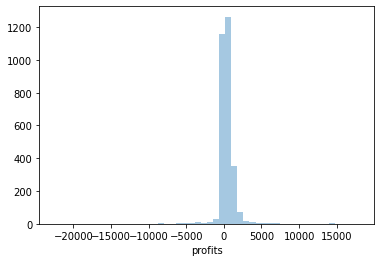

In [7]:
sns.distplot(sellers.profits, kde=False)

In [8]:
sorted_sellers = sellers.sort_values(by='profits')[['profits', 'n_orders', 'revenues']].reset_index()
sorted_sellers.head()

,index,profits,n_orders,revenues
0,769,-22499.517,1854,13770.483
1,2360,-19242.708,1806,21647.292
2,1358,-18051.158,1706,11948.842
3,946,-16032.248,1146,4677.752
4,315,-13066.431,943,2553.569


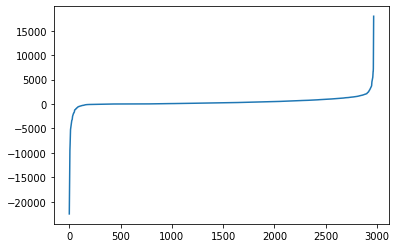

In [9]:
sorted_sellers.profits.plot()

### Compute Olist's net_profits for various seller cut-offs

In [10]:
# Let's create arrays "xxx_per_seller_removed" which list,
# for each number of seller removed (from 1 to len(seller)), 
# the value xxx computed in this hypothetic scenario

In [11]:
sorted_sellers.profits

0      -22499.517
1      -19242.708
2      -18051.158
3      -16032.248
4      -13066.431
          ...    
2965     6700.462
2966     7288.455
2967    14254.203
2968    14523.187
2969    17967.605
Name: profits, Length: 2970, dtype: float64

Text(0.5, 0, 'number of seller to remove')

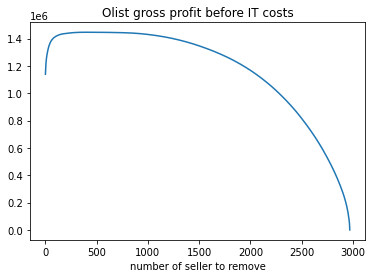

In [12]:
# Analysis before IT costs
revenues_per_seller_removed = olist_revenues - np.cumsum(sorted_sellers.revenues)
gross_profits_per_seller_removed = olist_gross_profits - np.cumsum(sorted_sellers.profits)

gross_profits_per_seller_removed.plot()
plt.title('Olist gross profit before IT costs')
plt.xlabel('number of seller to remove')

In [10]:
# Add the IT costs of Olist's platform, which scales as A * (n_orders)**0.5
# First, compute A
A = olist_it_costs_all_orders / (sellers['n_orders'].sum()**0.5)
A

1582.3735631973473

Text(0.5, 0, 'number of seller to remove')

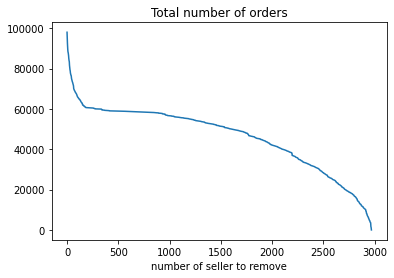

In [22]:
# Then, compute n_order per scenario
n_orders_per_seller_removed = sorted_sellers.n_orders.sum() - np.cumsum(sorted_sellers.n_orders)
plt.plot(n_orders_per_seller_removed)
plt.title('Total number of orders')
plt.xlabel('number of seller to remove')

Text(0.5, 0, 'number of seller to remove')

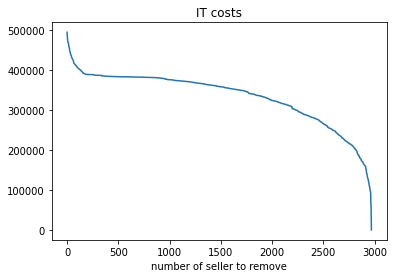

In [23]:
# Create array of it_costs per scenario
it_costs_per_seller_removed = A * n_orders_per_seller_removed**0.5
plt.plot(it_costs_per_seller_removed)
plt.title('IT costs')
plt.xlabel('number of seller to remove')

In [24]:
# Compute final metrics (profits and margin, for each 2970 scenarios!)
profits_per_seller_removed = gross_profits_per_seller_removed - it_costs_per_seller_removed
margin_per_seller_removed = profits_per_seller_removed / revenues_per_seller_removed

array([   0,    1,    2, ..., 2966, 2967, 2968])

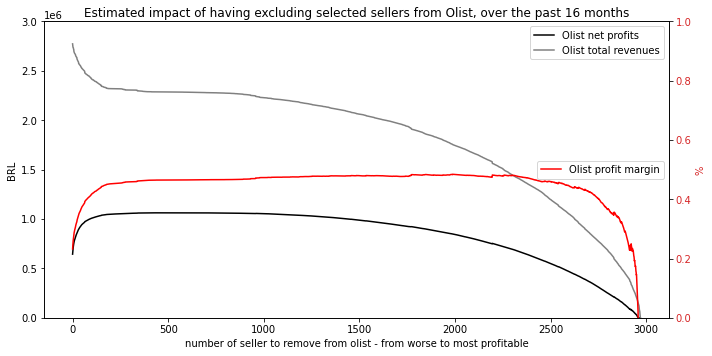

In [37]:
fig, ax1 = plt.subplots(figsize=(10,5))
x = np.arange(0, len(sellers), 1)

plt.suptitle("Estimated impact of having excluding selected sellers from Olist, over the past 16 months")

ax1.set_xlabel('number of seller to remove from olist - from worse to most profitable')
ax1.set_ylabel('BRL')
ax1.plot(x, profits_per_seller_removed, color='black', label='Olist net profits')
ax1.plot(x, revenues_per_seller_removed, color='grey', label='Olist total revenues')
ax1.legend()
ax1.tick_params(axis='y')
ax1.legend()
ax1.set(ylim=[0,3000000])


ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax3.set_ylabel('%', color=color)  # we already handled the x-label with ax1
ax3.plot(x, margin_per_seller_removed, color='red', label='Olist profit margin')
ax3.tick_params(axis='y', labelcolor=color)
ax3.legend(loc='right')
ax3.set(ylim=[0,1])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

☝️We can clearly see a trade-off with a maximim net_profit, at around 500 sellers to remove, and a maximum margin at about 2000 sellers removed. Beyond, margin collapses due to IT costs.

In [ ]:
# CEO-REQUEST CHALLENGE

## Problem statement

We would like to analyse the impact of removing the most-underperforming sellers from Olist marketplace.

❓ **Formulate the problem mathematically**

<details>
    <summary>Hints</summary>

1) You may want to compute, for each `seller_id`:
- The revenue it brings (10% of each sales + 80 BRL per month)
- The cost associated with all its bad reviews (1-star = 100 BRL, 2-star = 50, 3-star=40)
- and the resulting profit per seller
- cumulated over the course of the past 16 months of data we have
    
2) We may then sort sellers by increasing profit for Olist and compute, the financial impact it would have made if we had removed some sellers from the platform.

</details>

# What is the final DataFrame you need to build to answer the question?

# [seller_id, months_on_olist, sales, cost_of_reviews]

---
❓ Second, take time to **write down in plain english a step-by-step approach** to your goal. 

Try not to start from scratch, but think instead about what logic you have already coded in your `olist` package, and how can they be used **or modified** to give you the desired outcome. Your codebase is not set in stone - feel free to add new methods as needed!

<details>
    <summary>Hints for seller-removal analysis</summary>


Starting from your current `seller().get_training_data()` DataFrame:
- Can you easily transform it to compute Olist's positive `revenue_per_seller`? 
- Can you easily transform it to compute Olist's `cost_of_bad_reviews`? Not directly from the mean `review_score`

❓Instead of starting again from scratch, investigate in your source code in `seller.py` how was computed the mean `review_score` per seller. Can you imagine a way to ammend your code so as to compute `cost_of_reviews` in the same process ? 
</details>


# Write down a detailed strategy (steps by step) to get to this final DataFrame

- Update `seller.py` to compute a missing `cost_of_reviews` column
- Compute `months_on_olist` and `revenues` using existing seller_training_data columns
- Compute `profits` per seller
- Sort DataFrame per `profits`
- Remove worse performing seller one by one, and for each scenario:
    - compute `n_orders` and therefore `olist_it_costs` (prop to square root of n_orders)
    - compute Olist's total `net_profits` and `margin`
- Find the optimal number of seller to remove from platform so as to maximize `profit` or `margin`

## Update `seller.py`

from olist.seller_updated import Seller
seller = Seller()

## Economic analysis

olist_it_costs_all_orders = 500000

sellers = seller.get_training_data()

olist_revenues = sellers.revenues.sum()
olist_gross_profits = sellers.profits.sum()
olist_gross_profits

sns.distplot(sellers.profits, kde=False)

sorted_sellers = sellers.sort_values(by='profits')[['profits', 'n_orders', 'revenues']].reset_index()
sorted_sellers.head()

sorted_sellers.profits.plot()

### Compute Olist's net_profits for various seller cut-offs

# Let's create arrays "xxx_per_seller_removed" which list,
# for each number of seller removed (from 1 to len(seller)), 
# the value xxx computed in this hypothetic scenario

sorted_sellers.profits

# Analysis before IT costs
revenues_per_seller_removed = olist_revenues - np.cumsum(sorted_sellers.revenues)
gross_profits_per_seller_removed = olist_gross_profits - np.cumsum(sorted_sellers.profits)

gross_profits_per_seller_removed.plot()
plt.title('Olist gross profit before IT costs')
plt.xlabel('number of seller to remove')

# Add the IT costs of Olist's platform, which scales as A * (n_orders)**0.5
# First, compute A
A = olist_it_costs_all_orders / (sellers['n_orders'].sum()**0.5)
A

# Then, compute n_order per scenario
n_orders_per_seller_removed = sorted_sellers.n_orders.sum() - np.cumsum(sorted_sellers.n_orders)
plt.plot(n_orders_per_seller_removed)
plt.title('Total number of orders')
plt.xlabel('number of seller to remove')

# Create array of it_costs per scenario
it_costs_per_seller_removed = A * n_orders_per_seller_removed**0.5
plt.plot(it_costs_per_seller_removed)
plt.title('IT costs')
plt.xlabel('number of seller to remove')

# Compute final metrics (profits and margin, for each 2970 scenarios!)
profits_per_seller_removed = gross_profits_per_seller_removed - it_costs_per_seller_removed
margin_per_seller_removed = profits_per_seller_removed / revenues_per_seller_removed



fig, ax1 = plt.subplots(figsize=(10,5))
x = np.arange(0, len(sellers), 1)

plt.suptitle("Estimated impact of having excluding selected sellers from Olist, over the past 16 months")

ax1.set_xlabel('number of seller to remove from olist - from worse to most profitable')
ax1.set_ylabel('BRL')
ax1.plot(x, profits_per_seller_removed, color='black', label='Olist net profits')
ax1.plot(x, revenues_per_seller_removed, color='grey', label='Olist total revenues')
ax1.legend()
ax1.tick_params(axis='y')
ax1.legend()
ax1.set(ylim=[0,3000000])


ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax3.set_ylabel('%', color=color)  # we already handled the x-label with ax1
ax3.plot(x, margin_per_seller_removed, color='red', label='Olist profit margin')
ax3.tick_params(axis='y', labelcolor=color)
ax3.legend(loc='right')
ax3.set(ylim=[0,1])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

☝️We can clearly see a trade-off with a maximim net_profit, at around 500 sellers to remove, and a maximum margin at about 2000 sellers removed. Beyond, margin collapses due to IT costs.